# Welcome to the great Categorical Feature Encoding Challenge #2
This notebook is a starter code for all beginners and easy to understand. I used the following notebook to improve knowledge about encoding:
https://www.kaggle.com/shahules/an-overview-of-encoding-techniques

Additionally there are created new features based on the relationsship between the nominal features. <br>
It is used the XGB Classifier with a simple setting and great results.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from xgboost import XGBClassifier

# Input path

In [3]:
path_in = 'input/'
print(os.listdir(path_in))

['sample_submission.csv', 'test.csv', 'train.csv']


# Read input data

In [4]:
train_data = pd.read_csv(path_in+"train.csv", index_col=0)
test_data = pd.read_csv(path_in+"test.csv", index_col=0)
samp_subm = pd.read_csv(path_in+"sample_submission.csv", index_col=0)

# Plot bar function

In [5]:
def plot_bar(data, name):
    data_label = data[name].value_counts()
    dict_train = dict(zip(data_label.keys(), ((data_label.sort_index())).tolist()))
    names = list(dict_train.keys())
    values = list(dict_train.values())
    plt.bar(names, values)
    plt.grid()
    plt.show()

In [6]:
def plot_bar_compare(train, test, name, rot=False):
    """ Compare the distribution between train and test data """
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    
    train_label = train[name].value_counts().sort_index()
    dict_train = dict(zip(train_label.keys(), ((100*(train_label)/len(train.index)).tolist())))
    train_names = list(dict_train.keys())
    train_values = list(dict_train.values())
    
    test_label = test[name].value_counts().sort_index()
    dict_test = dict(zip(test_label.keys(), ((100*(test_label)/len(test.index)).tolist())))
    test_names = list(dict_test.keys())
    test_values = list(dict_test.values())
    
    axs[0].bar(train_names, train_values, color='yellowgreen')
    axs[1].bar(test_names, test_values, color = 'sandybrown')
    axs[0].grid()
    axs[1].grid()
    axs[0].set_title('Train data')
    axs[1].set_title('Test data')
    axs[0].set_ylabel('%')
    if(rot==True):
        axs[0].set_xticklabels(train_names, rotation=45)
        axs[1].set_xticklabels(test_names, rotation=45)
    plt.show()

# Overview
We have a look on the number of samples and check missing data. 

In [7]:
print('# samples train:', len(train_data))
print('# samples test:', len(test_data))

# samples train: 600000
# samples test: 400000


In [8]:
cols_with_missing_train_data = [col for col in train_data.columns if train_data[col].isnull().any()]
cols_with_missing_test_data = [col for col in test_data.columns if test_data[col].isnull().any()]
print('train cols with missing data:', cols_with_missing_train_data)
print('test cols with missing data:', cols_with_missing_test_data)

train cols with missing data: ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']
test cols with missing data: ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']


# Handle missing data
First we handle missing data by a simple imputer with the most-frequent strategy.

In [9]:
imp_cat = SimpleImputer(strategy='most_frequent')
train_data[cols_with_missing_train_data] = imp_cat.fit_transform(train_data[cols_with_missing_train_data])
test_data[cols_with_missing_test_data] = imp_cat.fit_transform(test_data[cols_with_missing_test_data])

# Show features

In [10]:
train_data.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'],
      dtype='object')

In [11]:
train_data.head()

bin_0  bin_1  bin_2 bin_3 bin_4 nom_0      nom_1    nom_2       nom_3  \
id                                                                          
0     0.0    0.0    0.0     F     N   Red  Trapezoid  Hamster      Russia   
1     1.0    1.0    0.0     F     Y   Red       Star  Axolotl       India   
2     0.0    1.0    0.0     F     N   Red   Triangle  Hamster      Canada   
3     0.0    0.0    0.0     F     N   Red     Circle  Hamster     Finland   
4     0.0    0.0    0.0     T     N   Red   Triangle  Hamster  Costa Rica   

       nom_4  ...      nom_9 ord_0        ord_1     ord_2 ord_3  ord_4 ord_5  \
id            ...                                                              
0    Bassoon  ...  02e7c8990   3.0  Contributor       Hot     c      U    Pw   
1   Theremin  ...  f37df64af   3.0  Grandmaster      Warm     e      X    pE   
2    Bassoon  ...  8f3276a6e   3.0       Novice  Freezing     n      P    eN   
3   Theremin  ...  f9d456e57   1.0       Novice  Lava Hot     a      C    Fl   
4   Theremin  ...  c5361037c   3.0  Grandmaster      Cold     h      C    OZ   

    day month target  
id                    
0   6.0   3.0      0  
1   7.0   7.0      0  
2   5.0   9.0      0  
3   3.0   3.0      0  
4   5.0  12.0      0  

[5 rows x 24 columns]

# Show target
We have a look on the distribution of the target values.

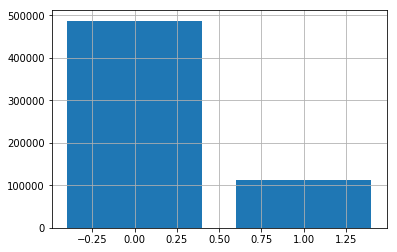

In [12]:
plot_bar(train_data, 'target')

# Classify the features

In [13]:
features_bin = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
features_cat = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
features_hex = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
features_ord = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
features_cyc = ['day', 'month']

# Define the scaler mappings for the ordinal features
For ord_0 is nothing to do.

In [14]:
map_ord_1 = {'Novice':1, 'Contributor':2, 'Expert':3, 'Master':4, 'Grandmaster':5}
map_ord_2 = {'Freezing': 1, 'Cold':2, 'Warm':3, 'Hot':4, 'Boiling Hot': 5, 'Lava Hot':6}
map_ord_3 = dict(zip(train_data['ord_3'].value_counts().sort_index().keys(),
                     range(1, len(train_data['ord_3'].value_counts())+1)))
map_ord_4 = dict(zip(train_data['ord_4'].value_counts().sort_index().keys(),
                     range(1, len(train_data['ord_4'].value_counts())+1)))

In [15]:
temp_ord_5 = pd.DataFrame(train_data['ord_5'].value_counts().sort_index().keys(), columns=['ord_5'])
temp_ord_5['First'] = temp_ord_5['ord_5'].astype(str).str[0].str.upper()
temp_ord_5['Second'] = temp_ord_5['ord_5'].astype(str).str[1].str.upper()
temp_ord_5['First'] = temp_ord_5['First'].replace(map_ord_4)
temp_ord_5['Second'] = temp_ord_5['Second'].replace(map_ord_4)
temp_ord_5['Add'] = temp_ord_5['First']+temp_ord_5['Second']
temp_ord_5['Mul'] = temp_ord_5['First']*temp_ord_5['Second']
map_ord_5 = dict(zip(temp_ord_5['ord_5'],
                     temp_ord_5['Mul']))

# Plot the nominal features and think about a relationsship
## Feature nom_0 - the color
Blue and Red are colors of the RGB color space, Green not.

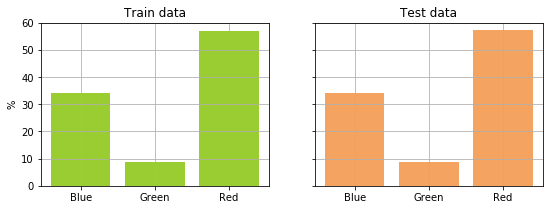

In [16]:
plot_bar_compare(train_data, test_data, 'nom_0')

In [17]:
train_data['rgb'] = np.where(train_data['nom_0'] == 'Green', 0, 1)
test_data['rgb'] = np.where(test_data['nom_0'] == 'Green', 0, 1)

## Feature nom_1 the geometric shape
Only the circle has no corners.

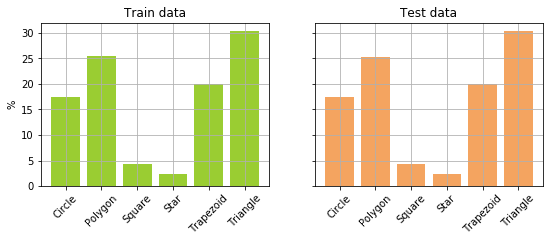

In [18]:
plot_bar_compare(train_data, test_data, 'nom_1', rot=True)

In [19]:
train_data['round'] = np.where(train_data['nom_1'] == 'Circle', 1, 0)
test_data['round'] = np.where(test_data['nom_1'] == 'Circle', 1, 0)

## Feature nom_2 - animals
The snake has no feet.

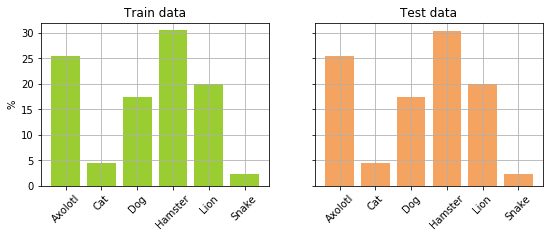

In [20]:
plot_bar_compare(train_data, test_data, 'nom_2', rot=True)

In [21]:
train_data['feet'] = np.where(train_data['nom_2'] == 'Snake', 0, 1)
test_data['feet'] = np.where(test_data['nom_2'] == 'Snake', 0, 1)

## Feature nom_3 - countries
Canda is a monarchy.

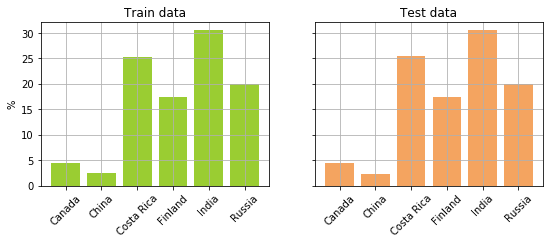

In [22]:
plot_bar_compare(train_data, test_data, 'nom_3', rot=True)

In [23]:
train_data['monarchy'] = np.where(train_data['nom_3'] == 'Canada', 1, 0)
test_data['monarchy'] = np.where(test_data['nom_3'] == 'Canada', 1, 0)

## Feature nom_4 - musical instruments
The Theremin is a electronical instrument.

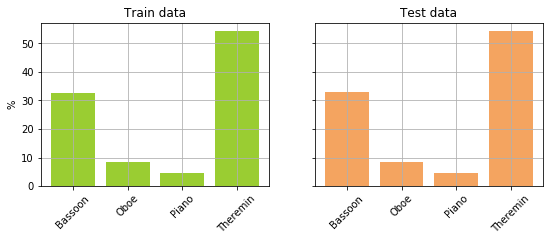

In [24]:
plot_bar_compare(train_data, test_data, 'nom_4', rot=True)

In [25]:
train_data['electro'] = np.where(train_data['nom_4'] == 'Theremin', 1, 0)
test_data['electro'] = np.where(test_data['nom_4'] == 'Theremin', 1, 0)

# Define y_train

In [26]:
y_train = train_data['target']
del train_data['target']

# Encode the features

In [27]:
X_train = train_data.copy()
X_test = test_data.copy()

## Binary features
Use the simple LabelEncoder.

In [28]:
le = LabelEncoder()
for col in features_bin:
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

## Categorical features
Use the simple LabelEncoder.

In [29]:
le = LabelEncoder()
for col in features_cat:
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

## Hexadecimal features
Use the simple LabelEncoder.

In [30]:
le = LabelEncoder()
for col in features_hex:
    le.fit(X_train[col].append(X_test[col]))
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

## Ordinal features
Use the mapping for ord_1 to ord_5.

In [31]:
X_train['ord_1'] = X_train['ord_1'].replace(map_ord_1)
X_train['ord_2'] = X_train['ord_2'].replace(map_ord_2)
X_train['ord_3'] = X_train['ord_3'].replace(map_ord_3)
X_train['ord_4'] = X_train['ord_4'].replace(map_ord_4)
X_train['ord_5'] = X_train['ord_5'].replace(map_ord_5)
X_test['ord_1'] = X_test['ord_1'].replace(map_ord_1)
X_test['ord_2'] = X_test['ord_2'].replace(map_ord_2)
X_test['ord_3'] = X_test['ord_3'].replace(map_ord_3)
X_test['ord_4'] = X_test['ord_4'].replace(map_ord_4)
X_test['ord_5'] = X_test['ord_5'].replace(map_ord_5)

## Cyclic features

In [32]:
for feature in features_cyc:
    X_train[feature+'_sin'] = np.sin((2*np.pi*X_train[feature])/max(X_train[feature]))
    X_train[feature+'_cos'] = np.cos((2*np.pi*X_train[feature])/max(X_train[feature]))
    X_test[feature+'_sin'] = np.sin((2*np.pi*X_test[feature])/max(X_test[feature]))
    X_test[feature+'_cos'] = np.cos((2*np.pi*X_test[feature])/max(X_test[feature]))
X_train = X_train.drop(features_cyc, axis=1)
X_test = X_test.drop(features_cyc, axis=1)

# Scale data

In [33]:
mean = X_train[features_hex].mean(axis=0)
X_train[features_hex] = X_train[features_hex].astype('float32')
X_train[features_hex] -= X_train[features_hex].mean(axis=0)
std = X_train[features_hex].std(axis=0)
X_train[features_hex] /= X_train[features_hex].std(axis=0)
X_test[features_hex] = X_test[features_hex].astype('float32')
X_test[features_hex] -= mean
X_test[features_hex] /= std

In [34]:
mean = X_train[features_ord].mean(axis=0)
X_train[features_ord] = X_train[features_ord].astype('float32')
X_train[features_ord] -= X_train[features_ord].mean(axis=0)
std = X_train[features_ord].std(axis=0)
X_train[features_ord] /= X_train[features_ord].std(axis=0)
X_test[features_ord] = X_test[features_ord].astype('float32')
X_test[features_ord] -= mean
X_test[features_ord] /= std

In [35]:
mean = X_train[features_cat].mean(axis=0)
X_train[features_cat] = X_train[features_cat].astype('float32')
X_train[features_cat] -= X_train[features_cat].mean(axis=0)
std = X_train[features_cat].std(axis=0)
X_train[features_cat] /= X_train[features_cat].std(axis=0)
X_test[features_cat] = X_test[features_cat].astype('float32')
X_test[features_cat] -= mean
X_test[features_cat] /= std

In [36]:
X_train.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'rgb', 'round', 'feet',
       'monarchy', 'electro', 'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

# Split train and val data

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2020)

# Calc the class wights of the target

In [38]:
weight = float(len(y_train[y_train == 0]))/float(len(y_train[y_train == 1]))
w1 = np.array([1]*y_train.shape[0])
w1[y_train==1]=weight

In [39]:
X_train[features_cat].head()

nom_0     nom_1     nom_2     nom_3     nom_4
id                                                      
328487  0.835160 -0.866343  1.164566 -0.955215 -1.310128
131182 -1.323234  1.137696  0.509421  1.298436 -1.310128
359687 -1.323234  0.636686 -0.145724  1.298436  0.141026
2274    0.835160 -1.367352  1.164566  0.547219 -1.310128
241998  0.835160 -0.866343  0.509421 -1.706432  0.866602

# Define XGBClassifier and Predict
Determine the parameters of the XGB Classifier with a simple grid search.
## Set model and fit

In [40]:
model = XGBClassifier(objective ='binary:logistic',
                      colsample_bytree = 0,
                      learning_rate = 0.2,
                      max_depth = 15,
                      n_estimators = 400,
                      scale_pos_weight = 2,
                      random_state = 2020,
                      subsample = 0.8)

In [41]:
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, sample_weight=w1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=0.8, verbosity=1)

## Evalaute the model with the val data

In [42]:
preds_val = model.predict_proba(X_val)[:,1]

In [43]:
score = metrics.roc_auc_score(y_val ,preds_val)
print("score: %f" % (score))

score: 0.777630


# Confusion Matrix
Example of confusion matrix usage to evaluate the quality of the output of a classifier data set. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [44]:
# metrics.plot_confusion_matrix(model,
#                               X_val, y_val,
#                               cmap=plt.cm.Blues,
#                               normalize=None,
#                               values_format='d')

## Predict test data

In [45]:
y_test = model.predict_proba(X_test)[:,1]

# Write the Export

In [46]:
num = samp_subm.index
output = pd.DataFrame({'id': num,
                       'target': y_test})
output.to_csv('submission.csv', index=False)